# Construct an Yeast Cell Representation

In this tutorial, you will learn how to construct a cell and add features at specific locations. We will construct an model of an Yeast cell using the Builder feature and idealized shapes provided by Lattice Microbes.

The specification of an RDME simulation will generally occur in the order:

1. Define simulation volume
2. Define region types
3. Specify reaction model
4. Specify diffusion model
5. Create simulation geometry
6. Customize simulation initial conditions

In [1]:
import os
import lm
import pyLM
from pyLM.RDME import RDMESimulation
from pyLM.units import *
import pySTDLM
from pyLM.ipyInterface import visualizeRDMEInitialConditions

import numpy as np
import math
import scipy as sp
import scipy.spatial

import matplotlib.pyplot as plt
%matplotlib notebook

## Create an RDME Simulation about the volume of a Yeast Cell

First, a simulation domain is created that can hold an Yeast cell. Cells are generally about 4 $\mu m$ for a sidelength.

In [2]:
sim = RDMESimulation(dimensions=micron(4.096,4.096,4.096), 
                     spacing=nm(16), 
                     name="Yeast Cell Model", 
                     defaultRegion="extracellular")

## Define the Reaction and Diffusion Models


### Create Region Types

After defining the simulation volume, the types of possible regions are defined. We use "region types" and "site types" interchangabely when talking about simulations. Region types do not define an actual spatial location, but a type of locations that have distinct reaction and diffusion characteristics.

In this simulation, we will have three main region types:

1. membrane - the cell membrane
2. cytoplasm - the region that is generally free of DNA
3. nucleus - the cell membrane for the nucleus
4. nucleoplasm - the inside of the nucleus
5. vesicle - the vesicle
6. vacuole - the vacuole
7. mitochondria - the mitochondria 

In [3]:
mem = sim.addRegion("membrane")
cyt = sim.addRegion("cytoplasm")
nuc = sim.addRegion("nucleus")
npl = sim.addRegion("nucleoplasm")
ves = sim.addRegion("vesicle")
vac = sim.addRegion("vacuole")
mit = sim.addRegion("mitochondria")
ext = sim.modifyRegion("extracellular")

### Reaction Model

We define a toy gene expression model (with reasonable rates):

1. D - Gene
3. M - mRNA transcribed from gene
5. P - protein translated from mRNA
6. R - ribosomes

Production reactions

$D \longrightarrow D+M$

$R+M \longrightarrow R+M+P$

Degradation reactions

$M \longrightarrow \emptyset$

$P \longrightarrow \emptyset$

In [4]:
# Define the species
species = ['D','M','P','R']
sim.defineSpecies(species)

# Production Reactions
npl.addReaction(reactant='D', product=('D','M'), rate=0.1)
for reg in [cyt, mem]:
    reg.addReaction(reactant=('R','M'), product=('R','M','P'), rate=1e-6)

# Degradation reactions
for reg in [cyt, mem]:
    reg.addReaction(reactant='M', product='', rate=0.0033)
    reg.addReaction(reactant='P', product='', rate=1.0/(20.0*60.0))

### Diffusion Model

Next, we define how particles diffuse in and among different region types. Diffusion rates are in MKS units (e.g. $m^2/s$)

Two types of diffusions need to be defined:

1. Intra-region diffusion - set with code of the form `region.setDiffusionRate(species=..., rate=...)`
2. Inter-region diffusion - set with code ofthe form `simulation.setTwoWayTransitionRate(species=..., one=..., two=..., rate=...)`

In [5]:
# mRNA diffusion dates
npl.setDiffusionRate(species="M", rate=5e-14)
nuc.setDiffusionRate(species="M", rate=5e-13)
cyt.setDiffusionRate(species="M", rate=5e-13)
sim.setTwoWayTransitionRate(species='M',one='nucleoplasm', two='nucleus',   rate=5e-13)
sim.setTwoWayTransitionRate(species='M',one='nucleus',     two='cytoplasm', rate=5e-13)

# Protein diffusion rates
_ = cyt.setDiffusionRate(species='P', rate=5e-12)


### Add Particles that are Randomly Distributed

When the starting location of particles isn't important, we just call the `sim.addParticles(...)` function. At the time of discretization (see below) particles will be randomly placed within the volumes that are defined as each region type.

In [6]:
sim.addParticles(species='D', region='nucleoplasm', count=1)
sim.addParticles(species='M', region='cytoplasm', count=300)
sim.addParticles(species='P', region='cytoplasm', count=10000)
sim.addParticles(species='R', region='cytoplasm', count=217000)

# Display the simulation setup
sim

## Build Spatial Regions

Next we will define the spatial model for the simulation, in other words, we will define which parts of the simulation domain correspond to which region types. We will create a cell that is ellipsoidal about 4 $\mu m$ in diameter. Additionally, the membrane on the outside will be 32 $nm$ wide. This is unrealistically large, however, it will ensure that there are no holes in the membrane.

In [7]:
radius1 = micron(2.0) # Radius of the cell in the long direction
radius2 = micron(1.75) # Radius of the cell inthe short direction
membraneThickness = nm(32) # Membrane thickness (2 lattice sites to prevent holes)

allShapes = []

### Cell Membrane and Cytoplasm

The cell builder code in Lattice Microbes works like a paint canvas. Because each location in the lattice can only correspond with a single region type, the most recently applied shape will overwrite any previous applied. In this way, we will "paint" the structures one; first a spherocylinder for the membranem type, then another spherocylinder slightly smaller with a cytoplasm type, finally a much smaller spherocylinder for the nucleoid type.

In [8]:
# Points take absolue coordinates
center = lm.point(*micron(2.048,2.048,2.048))

# Construct a Ellipsoid for the outside of the membrane
cellMembrane = lm.Ellipse(center, 
                          radius2, radius1, radius2, 
                          sim.siteTypes['membrane'])

# Construct a Ellipsoid for the outside of the membrane
cellCytoplasm = lm.Ellipse(center, 
                           radius2-membraneThickness, 
                           radius1-membraneThickness, 
                           radius2-membraneThickness, 
                           sim.siteTypes['cytoplasm'])

### Cell Nucleus

In [9]:
# Construct a sphere for the nucleus
nucleusRadius = micron(0.713)

nucCenter = lm.point(micron(2.048),micron(2.048), micron(1.3))
cellNucleusMem = lm.Sphere(nucCenter, 
                           nucleusRadius, 
                           sim.siteTypes['nucleus'])
cellNucleus    = lm.Sphere(nucCenter, 
                           nucleusRadius - membraneThickness, 
                           sim.siteTypes['nucleoplasm'])

allShapes.append(cellNucleusMem)

### Vacuoles

In [10]:
# Bionumbers says there are 2+-1.7 vacuoles
vacuoleRadius = micron(0.3)

vacCenter1 = lm.point(*micron(1.5,2.7,2.5))
vac1 = lm.Sphere(vacCenter1,
                 vacuoleRadius,
                 sim.siteTypes['vacuole'])
vacCenter2 = lm.point(*micron(2.7,1.5,3.3))
vac2 = lm.Sphere(vacCenter2,
                 vacuoleRadius,
                 sim.siteTypes['vacuole'])

allShapes.append(vac1)
allShapes.append(vac2)

### Mitochondria

In [11]:
# Bionumbers says there are 2.3+-1.2 vacuoles
mitRadius = micron(0.135)
pm1 = lm.point(*micron(2.0,2.0,2.1))
pm2 = lm.point(*micron(2.27,1.75,2.15))
mit1 = lm.Capsule(pm1, pm2, mitRadius, sim.siteTypes['mitochondria'])

pm3 = lm.point(*micron(3.3, 1.3, 2.2))
pm4 = lm.point(*micron(3.3, 1.8, 2.3))
mit2 = lm.Capsule(pm3, pm4, mitRadius, sim.siteTypes['mitochondria'])

allShapes.append(mit1)
allShapes.append(mit2)

### Vesicles

In [12]:
# Bionumbers says there are 9.7+-6.4 vesicles
vesicleRadius = nm(50)
vesicles = []

for i in range(10):
    placed = False
    while not placed:
        # Generate a random point
        x = micron( np.random.random(1)*4.096)
        y = micron( np.random.random(1)*4.096)
        z = micron( np.random.random(1)*4.096)
        point = lm.point(x, y, z)
        ves = lm.Sphere(point, vesicleRadius, sim.siteTypes['vesicle'])

        # Make sure objects is inside the shell
        if not lm.Sphere(center, radius2, sim.siteTypes['cytoplasm']).contains(ves):
            continue
        
        # Test whether it collides with another object
        failed = False
        for obj in allShapes:
            if obj.intersects(ves):
                failed = True
                break
                
        # Try placing in another location           
        if failed:
            continue
            
        # Add vesicle
        allShapes.append(ves)
        ves.thisown = 0
        vesicles.append(ves)
        placed = True

### Add shapes to the LM Builder

In the last two code cells we created many objects. Once create, we layer these objects by adding them to the lm_builder object that is associated with the RDMESimulation object. This is the act of "painting" them to the canvas.

In [13]:
# Layer each object into the simulation domain (this paints each layer in order)
sim.lm_builder.addRegion(cellMembrane)
sim.lm_builder.addRegion(cellCytoplasm)
sim.lm_builder.addRegion(cellNucleusMem)
sim.lm_builder.addRegion(cellNucleus)
sim.lm_builder.addRegion(vac1)
sim.lm_builder.addRegion(vac2)
sim.lm_builder.addRegion(mit1)
sim.lm_builder.addRegion(mit2)
for v in vesicles:
    sim.lm_builder.addRegion(v)

## Visualize Simulation Intial Conditions

Finally, we can visualize the cell. To do this, we will use a function in pyLM that allows interactive visualization inside the Jupyter notebook. The GUI allows you to navigate through slices along the different axes (x, y, or z) and display different sets of particles (by shift- or control-clicking). Additionally, you can click within the image to get information about the site type and the particles contained within.

<IPython.core.display.Javascript object>


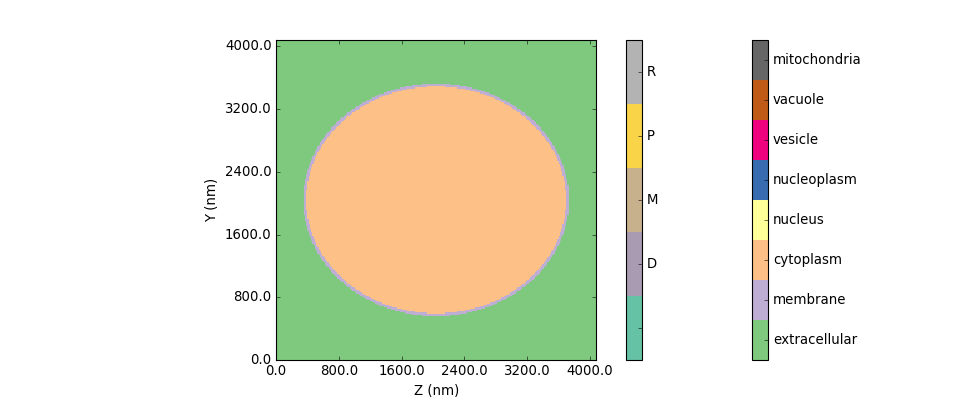

Widget Javascript not detected.  It may not be installed or enabled properly.


In [14]:
# Call this function to create an interactive widget in the Jupyter notebook to visualize data.
visualizeRDMEInitialConditions(sim)

In [15]:
# Save the simulation file to allow visualization with external software (e.g. VisIt or VMD)
try:
    os.remove('tut2.5-Yeastcell.lm')
except:
    pass
sim.save("tut2.5-Yeastcell.lm")